In [ ]:
import copy
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import hstack
from sklearn.preprocessing import StandardScaler
import datetime
import time
import joblib
from datetime import timedelta, date
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme() 
import errno
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
import pickle
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from scipy import interp
from imblearn.over_sampling import SMOTE
from collections import Counter
import imblearn
import collections
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def load_data_south_indian(url):
  df = pd.read_csv(url)
  #df.columns = ['id','date','longitude','latitude','speed']
  #df = df.drop(['date'], axis = 1)
  df['category'] = df['Speed(knots)'].apply(lambda x: 
  0 if x<=33 else 1  if x<=47 and x>=34 else 2 if x<=63 and x>=48 else 3 if x<=89 and x>=64 else 4 if x<=115 and x>=90 else 5 )
  return df

def load_data_south_pacific(url):
  df = pd.read_csv(url)
  #df.columns = ['id','date','longitude','latitude','speed']
  #df = df.drop(['date'], axis = 1)
  df['category'] = df['Speed(knots)'].apply(lambda x: 
  0 if x<=33 else 1  if x<=47 and x>=34 else 2 if x<=63 and x>=48 else 3 if x<=85 and x>=64 else 4 if x<=107 and x>=86 else 5 )
  return df

In [ ]:
ocean = 'south_pacific'  #south_indian or south_pacific
print(ocean)

if ocean == 'south_indian':
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_indian_hurricane.csv'
    function = load_data_south_indian
    hot_encoded_result_file_name = 'south_indian'
    category_result_file_name = 'roc_data_south_indian'
else:
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_pacific_hurricane.csv'
    function = load_data_south_pacific
    hot_encoded_result_file_name = 'south_pacific'
    category_result_file_name = 'roc_data_south_pacific' 

south_pacific


In [ ]:
df = function(url_data)
speed = df['Speed(knots)'].tolist()
categories = df['category'].tolist()
df.head()

,Basin,No. of Cycl,Time,V5,V6,Lat,Lon,Speed(knots),lat_tenth,lon_tenth,category
0,SP,14,1982012518,BEST,0,180S,1541E,25,18.0,154.1,0
1,SP,14,1982012600,BEST,0,191S,1548E,25,19.1,154.8,0
2,SP,14,1982012606,BEST,0,197S,1557E,25,19.7,155.7,0
3,SP,14,1982012612,BEST,0,199S,1567E,30,19.9,156.7,0
4,SP,14,1982012618,BEST,0,201S,1578E,35,20.1,157.8,1


In [ ]:
def split_sequence(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, -1 ]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# split a univariate sequence into samples
def uni_split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y) 
 
def rmse(pred, actual):
    return np.sqrt(((pred-actual) ** 2).mean())

def categorical(pred, actual):
  cm = confusion_matrix(pred,actual)
  ps = precision_score(pred,actual,average='micro')
  rs = recall_score(pred,actual,average='micro')
  f1 = f1_score(pred,actual, average = 'micro')
  return cm,ps,rs,f1

def make_confusion_matrix_chart(cf_matrix_test):
    plt.figure(1, figsize=(10,5))
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=['0','1'], 
                                xticklabels=['0','1'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.title('Test data')
    return None  

In [ ]:
univariate = True # if false, its multivariate case
n_steps_in = 4
n_seq = 2
n_steps_out = 1
n_features_in = 1 #speed
n_features_out = 6 # one hot encoding of category
Hidden = 10
Epochs = 100
Num_Exp = 3

In [ ]:
id = df['No. of Cycl'][0]
count = 0
X = []
Y = []
start_index=0
end_index=0
for i in range(1, df.shape[0]):
  if df['No. of Cycl'][i] == id :
    end_index+=1
  else:
    x,y = uni_split_sequence(speed[start_index:end_index+1], n_steps_in)
    X.append(x)
    Y.append(y)
    id = df['No. of Cycl'][i]
    start_index=i
    end_index=i
  if i == df.shape[0]-1:   
    x,y = uni_split_sequence(speed[start_index:end_index+1], n_steps_in)
    X.append(x)
    Y.append(y)    

In [ ]:
print(len(X), len(Y))
X = [item for sublist in X for item in sublist]
Y = [item for sublist in Y for item in sublist]
print(len(X), len(Y))
print(X[0], Y[0], X[1], Y[1])
print(speed[:10])

391 391
10460 10460
[25 25 25 30] 35 [25 25 30 35] 40
[25, 25, 25, 30, 35, 40, 40, 40, 40, 40]


In [ ]:
tmp = pd.DataFrame({'col': Y})
if ocean == 'south_pacific':
  category = tmp['col'].apply(lambda x: 
  0 if x<=33 else 1  if x<=47 and x>=34 else 2 if x<=63 and x>=48 else 3 if x<=85 and x>=64 else 4 if x<=107 and x>=86 else 5 )
else:
  category = tmp['col'].apply(lambda x: 
  0 if x<=33 else 1  if x<=47 and x>=34 else 2 if x<=63 and x>=48 else 3 if x<=89 and x>=64 else 4 if x<=115 and x>=90 else 5 )

Y=category

In [ ]:
train_limit = int(len(X)*70/100)
train_limit

7322

In [ ]:
test_X_original = X[train_limit+1:]
#X_original = X[:train_limit]
#X_original = np.asarray(X_original).astype(float)
test_Y_original = Y[train_limit+1:]
#Y_original = Y[:train_limit]
len(X), len(Y), len(test_X_original), len(test_Y_original)

(10460, 10460, 3137, 3137)

In [ ]:
X = MinMaxScaler().fit_transform(np.asarray(X))

In [ ]:
speed_x = X
test_X = X[train_limit+1:]
test_X = np.asarray(test_X).astype(float)
test_Y = Y[train_limit+1:]
X = X[:train_limit]
X = np.asarray(X).astype(float)
Y = Y[:train_limit]
print(len(test_X), len(test_Y))
len(X), len(Y)

3137 3137


(7322, 7322)

In [ ]:
counter_train = Counter(Y)
counter_test = collections.OrderedDict(sorted(Counter(test_Y).items()))
print("train data: ", counter_train)
print("test data: ", counter_test)

train data:  Counter({0: 1965, 1: 1869, 2: 1190, 3: 1155, 4: 698, 5: 445})
test data:  OrderedDict([(0, 547), (1, 581), (2, 525), (3, 716), (4, 465), (5, 303)])


<Figure size 432x288 with 0 Axes>

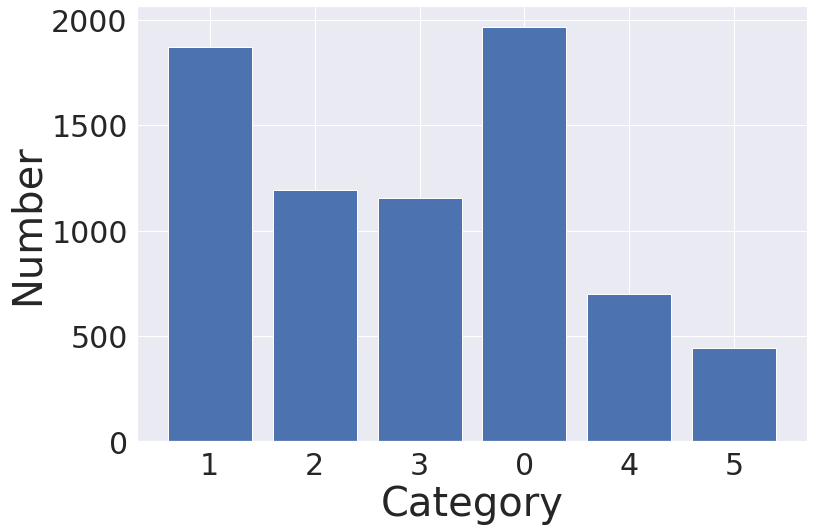

In [ ]:
plt.figure()
#fig = plt.subplots(figsize =(20, 12))
fig, ax = plt.subplots(figsize = (12,8))
plt.bar(range(len(counter_train)), list(counter_train.values()), align='center')
plt.xticks(range(len(counter_train)), list(counter_train.keys()))
plt.xlabel('Category', size=40)
plt.ylabel('Number', size=40)
#plt.title('ROC' + ' (' + str(no_of_output_steps) + ' steps ahead, ' + model.capitalize() + ', Time step: ' + str(time_step) + ') - ' + train_or_test.capitalize() + ' (' + ocean + '_ocean)')
ax.tick_params(axis='both', which='major', labelsize=30)
plt.savefig(ocean + '_class_dist.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

In [ ]:
def vanilla(n_steps_in,n_steps_out,n_features_in, n_features_out):
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features_in)))
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model
 
  #model = Sequential()
  #model.add(LSTM(Hidden, activation='relu', input_shape=(n_steps_in, n_features_in)))
  #model.add(RepeatVector(n_steps_out))
  #model.add(LSTM(Hidden, activation='relu', return_sequences=True))
  #model.add(TimeDistributed(Dense(n_features_out, activation = "softmax")))
  #model.compile(optimizer='adam', loss='categorical_crossentropy')
  #return model

def bidirectional(n_steps_in,n_steps_out,n_features_in, n_features_out):
  model = Sequential()
  model.add(Bidirectional(LSTM(Hidden, activation='relu', input_shape=(n_steps_in, n_features_in))))
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

def cnn_lstm(n_steps_in,n_steps_out,n_features_in, n_features_out, n_seq):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, int(n_steps_in/n_seq), n_features_in)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(Hidden, activation='relu'))
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

def conv_lstm(n_steps_in,n_steps_out,n_features_in, n_features_out, n_seq):
  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, int(n_steps_in/n_seq), n_features_in)))
  model.add(Flatten())
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

In [ ]:
#all models
def MODEL_LSTM(model_name, method, univariate, x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):

    train_acc = np.zeros(Num_Exp)
    test_acc = np.zeros(Num_Exp)

    if model_name == 'vanilla':
      model = vanilla(n_steps_in,n_steps_out,n_features_in, n_features_out)
    elif model_name == 'bidirectional':
      model = bidirectional(n_steps_in,n_steps_out,n_features_in, n_features_out)
    elif model_name == 'cnn-lstm':
      model = cnn_lstm(n_steps_in,n_steps_out,n_features_in,n_features_out,n_seq)
    elif model_name == 'conv-lstm':
      model = conv_lstm(n_steps_in,n_steps_out,n_features_in,n_features_out,n_seq)
    
    #model.summary()

    y_predicttest_allruns = np.zeros([Num_Exp, x_test.shape[0], y_test.shape[1]])

    #print(y_predicttest_allruns.shape, ' shape ')


    Best_f1 = 0  # Assigning a small number
    act_test = [y_test[i].argmax() for i in range(y_test.shape[0])]
    act_train = [y_train[i].argmax() for i in range(y_train.shape[0])]
    start_time = time.time()
    Best_report_train = dict()
    Best_report_test = dict()
    for run in range(Num_Exp):
        print("Experiment", run + 1, "in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs, batch_size=10, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        #y_predicttest_allruns[run,:,:] = y_predicttest
        #train_acc[run] = rmse(y_predicttrain, y_train)
        #print(train_acc[run], 'train accuracy')
        #test_acc[run] = rmse(y_predicttest, y_test)
        pred_test = [y_predicttest[i].argmax() for i in range(y_predicttest.shape[0])]
        pred_train = [y_predicttrain[i].argmax() for i in range(y_predicttrain.shape[0])]
        report_train = classification_report(act_train, pred_train, labels=[0,1,2,3,4,5], output_dict=True)
        report_test = classification_report(act_test, pred_test, labels=[0,1,2,3,4,5], output_dict=True)
        #test_acc[run] = f1_score(pred,act, average = 'binary')
        test_acc[run] = report_test['1']['f1-score']
        print("train acc: ", report_train['1']['f1-score'])        
        print("test acc: ", test_acc[run])
        if test_acc[run] > Best_f1:
            Best_f1 = test_acc[run]
            Best_Predict_Test = y_predicttest
            Best_report_train, Best_report_test = report_train, report_test
    model.save("model_" + ocean+"_"+model_name+"_"+method+'.h5')  
    train_std = np.std(train_acc)
    test_std = np.std(test_acc)
    print("Total time for", Num_Exp, "experiments", time.time() - start_time)
    print("f1 scores for test data: ", test_acc)
    return train_acc, test_acc, train_std, test_std, Best_Predict_Test, y_predicttrain, y_predicttest, Best_report_train, Best_report_test

In [ ]:
#idx = np.random.permutation(len(X_smote))
idx = np.random.permutation(len(X))
print(len(idx))
x_shuffled = []
y_shuffled = []
for i in idx:
  #x_shuffled.append(X_smote[i])
  #y_shuffled.append(Y_smote[i])
  x_shuffled.append(X[i])
  y_shuffled.append(Y[i])

7322


In [ ]:
Y_hot_encoded_train =  np.asarray(to_categorical(y_shuffled))
#Y_hot_encoded_train = Y_hot_encoded_train.reshape(len(y_shuffled), n_steps_out, n_features_out)

Y_hot_encoded_test =  np.asarray(to_categorical(test_Y))
#Y_hot_encoded_test = Y_hot_encoded_test.reshape(len(test_Y), n_steps_out, n_features_out)

print(Y_hot_encoded_train.shape, Y_hot_encoded_test.shape)

(7322, 6) (3137, 6)


In [ ]:
x_shuffled[0], test_X[0]

(array([0.17857143, 0.21428571, 0.25      , 0.32142857]),
 array([0.07142857, 0.07142857, 0.10714286, 0.10714286]))

In [ ]:
#models = ['vanilla', 'bidirectional', 'cnn-lstm', 'conv-lstm']
models = ['vanilla']
predictions_train = dict()
actual_train = dict()
predictions_test = dict()
actual_test = dict()
metrics_train = dict()
metrics_test = dict()

In [ ]:
for j in range(1):
    predictions_train_per_step = dict()
    actual_train_per_step = dict()  
    predictions_test_per_step = dict()
    actual_test_per_step = dict()
    metrics_train_per_step = dict()
    metrics_test_per_step = dict()
    n_steps_out = j+1
    print('---------------------------------------------------------')
    print('no of steps out: ', n_steps_out)

    for i in models:
        print("for " + i + ":")

        if i == 'vanilla' or i=='bidirectional':
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
            x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))
        elif i == 'cnn-lstm':
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))
            x_test = x_test.reshape((x_test.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))
        elif i=='conv-lstm':
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))
            x_test = x_test.reshape((x_test.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))
        
        #print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
        train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, report_train, report_test = MODEL_LSTM(i,'original', univariate,x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs, Hidden)
        predictions_train_per_step[i] = y_predicttrain
        actual_train_per_step[i] = y_train
        predictions_test_per_step[i] = Best_Predict_Test
        actual_test_per_step[i] = y_test
        metrics_train_per_step[i] = report_train
        metrics_test_per_step[i] = report_test 
    predictions_train[str(j+1)] = predictions_train_per_step 
    actual_train[str(j+1)] = actual_train_per_step
    predictions_test[str(j+1)] = predictions_test_per_step 
    actual_test[str(j+1)] = actual_test_per_step
    metrics_train[str(j+1)] = metrics_train_per_step
    metrics_test[str(j+1)] = metrics_test_per_step
  

---------------------------------------------------------
no of steps out:  1
for vanilla:
Experiment 1 in progress
train acc:  0.8185388845247445
test acc:  0.7732217573221757
Experiment 2 in progress
train acc:  0.828240252897787
test acc:  0.7819548872180451
Experiment 3 in progress
train acc:  0.8310864393338618
test acc:  0.7791771620486986
Total time for 3 experiments 461.0050718784332
f1 scores for test data:  [0.77322176 0.78195489 0.77917716]


In [ ]:
with open("predictions_" + ocean + '_original' + '.pkl', 'wb') as f: 
    pickle.dump([predictions_train,actual_train,predictions_test,actual_test,metrics_train,metrics_test], f)

In [ ]:
def make_confusion_matrix_chart2(cf_matrix_test, name):
    #plt.figure(figsize=(20,12))
    sns.set(font_scale=2.5)
    fig, ax = plt.subplots(figsize = (20,12))
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=['0','1','2','3','4','5'], 
                                xticklabels=['0','1','2','3','4','5'], fmt='g')
    plt.ylabel("Actual", size=30)
    plt.xlabel("Pred", size=30)
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.savefig(name + '.png', dpi=300, transparent=False, bbox_inches='tight')
    return None 

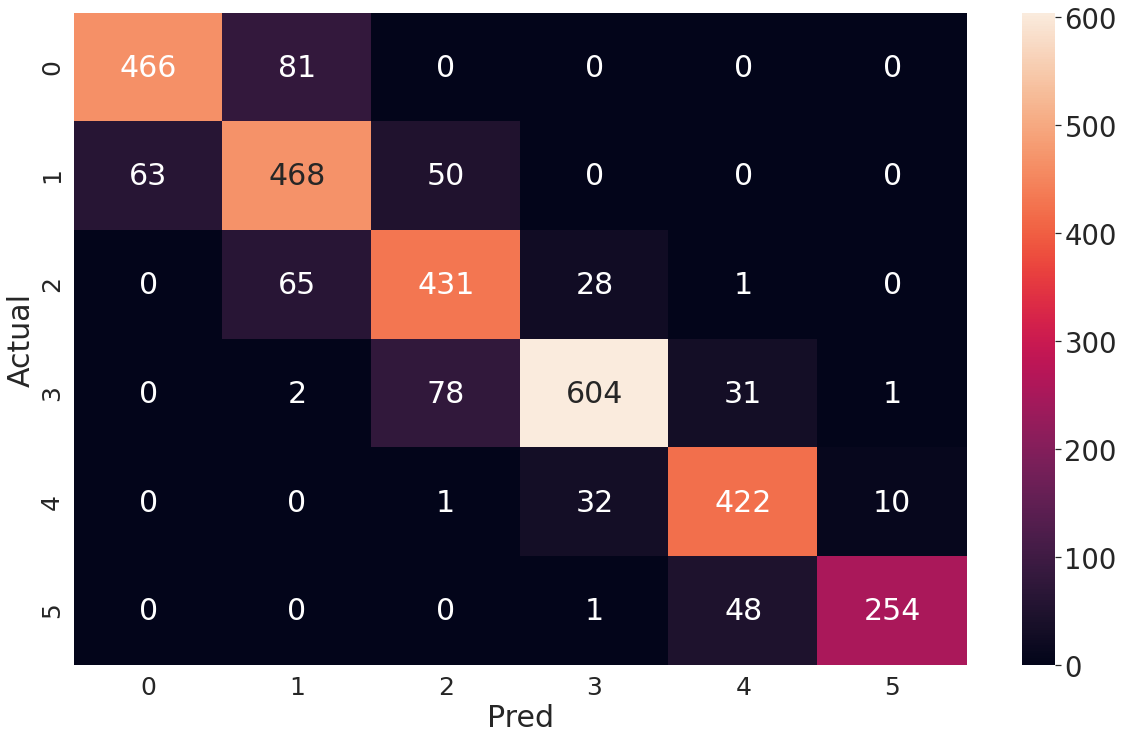

In [ ]:
y = [i.argmax() for i in actual_test_per_step['vanilla']]
pred = [i.argmax() for i in predictions_test_per_step['vanilla']]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart2(cf_matrix_test, ocean + '_vanilla_cm_original')

In [ ]:
report_df = pd.DataFrame(metrics_test_per_step['vanilla']).transpose()
report_df = report_df.reset_index()
model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
report_df

,index,precision,recall,f1-score,support
0,0,0.880907,0.851920,0.866171,547.000000
1,1,0.759740,0.805508,0.781955,581.000000
2,2,0.769643,0.820952,0.794470,525.000000
3,3,0.908271,0.843575,0.874728,716.000000
4,4,0.840637,0.907527,0.872802,465.000000
5,5,0.958491,0.838284,0.894366,303.000000
6,accuracy,0.843162,0.843162,0.843162,0.843162
7,macro avg,0.852948,0.844628,0.847416,3137.000000
8,weighted avg,0.847615,0.843162,0.844233,3137.000000


In [ ]:
for i in range(report_df.shape[0]):
  tmp=""
  for j in ['precision', 'recall', 'f1-score', 'support']:
    tmp=tmp+ str(round(report_df[j][i],4)) + " & "
  print(tmp)

0.8809 & 0.8519 & 0.8662 & 547.0 & 
0.7597 & 0.8055 & 0.782 & 581.0 & 
0.7696 & 0.821 & 0.7945 & 525.0 & 
0.9083 & 0.8436 & 0.8747 & 716.0 & 
0.8406 & 0.9075 & 0.8728 & 465.0 & 
0.9585 & 0.8383 & 0.8944 & 303.0 & 
0.8432 & 0.8432 & 0.8432 & 0.8432 & 
0.8529 & 0.8446 & 0.8474 & 3137.0 & 
0.8476 & 0.8432 & 0.8442 & 3137.0 & 


In [ ]:
oversample = SMOTE()
X_smote, Y_smote = oversample.fit_resample(X, Y)
X_smote = X_smote.astype(np.float)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
X.shape, test_X.shape, X_smote.shape

((7322, 4), (3137, 4), (11790, 4))

In [ ]:
counter = Counter(Y_smote)
print(counter)
print(len(X_smote), len(X))
print("old smote data after 10000 index: ", Counter(Y_smote[10000:]))

idx = np.random.permutation(len(X_smote))
print(len(idx))

x_shuffled = []
y_shuffled = []
for i in idx:
  x_shuffled.append(X_smote[i])
  y_shuffled.append(Y_smote[i])

print("shuffled smote data after 10000 index: ", Counter(y_shuffled[10000:]))
Y_hot_encoded_train =  np.asarray(to_categorical(y_shuffled))
#Y_hot_encoded_train = Y_hot_encoded_train.reshape(len(y_shuffled), n_steps_out, n_features_out)

Y_hot_encoded_test =  np.asarray(to_categorical(test_Y))
#Y_hot_encoded_test = Y_hot_encoded_test.reshape(len(test_Y), n_steps_out, n_features_out)

Y_hot_encoded_train.shape, Y_hot_encoded_test.shape

Counter({1: 1965, 2: 1965, 3: 1965, 0: 1965, 4: 1965, 5: 1965})
11790 7322
old smote data after 10000 index:  Counter({5: 1520, 4: 270})
11790
shuffled smote data after 10000 index:  Counter({5: 311, 3: 305, 0: 301, 1: 294, 2: 294, 4: 285})


((11790, 6), (3137, 6))

In [ ]:
[ i for i in x_shuffled if i[3]>=1]

[array([0.57142857, 0.75      , 1.        , 1.        ]),
 array([1., 1., 1., 1.]),
 array([0.96428571, 0.97741318, 0.97741318, 1.        ]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([0.99018373, 1.        , 1.        , 1.        ]),
 array([0.98340267, 1.        , 1.        , 1.        ]),
 array([0.98897019, 0.98897019, 1.        , 1.        ]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([0.53571429, 0.57142857, 0.75      , 1.        ]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([0.96428571, 1.        , 1.        , 1.        ]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([0.98099585, 1.        , 1.        , 1.        ]),
 array([1., 1., 

In [ ]:
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
            x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))

In [ ]:
train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, report_train, report_test = MODEL_LSTM('vanilla', 'smote', univariate,x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs, Hidden)

Experiment 1 in progress
train acc:  0.8002054442732408
test acc:  0.7506471095772218
Experiment 2 in progress
train acc:  0.8133646567475854
test acc:  0.7471365638766521
Experiment 3 in progress
train acc:  0.8144058885383806
test acc:  0.7493309545049063
Total time for 3 experiments 559.8821361064911
f1 scores for test data:  [0.75064711 0.74713656 0.74933095]


**SMOTE Results**

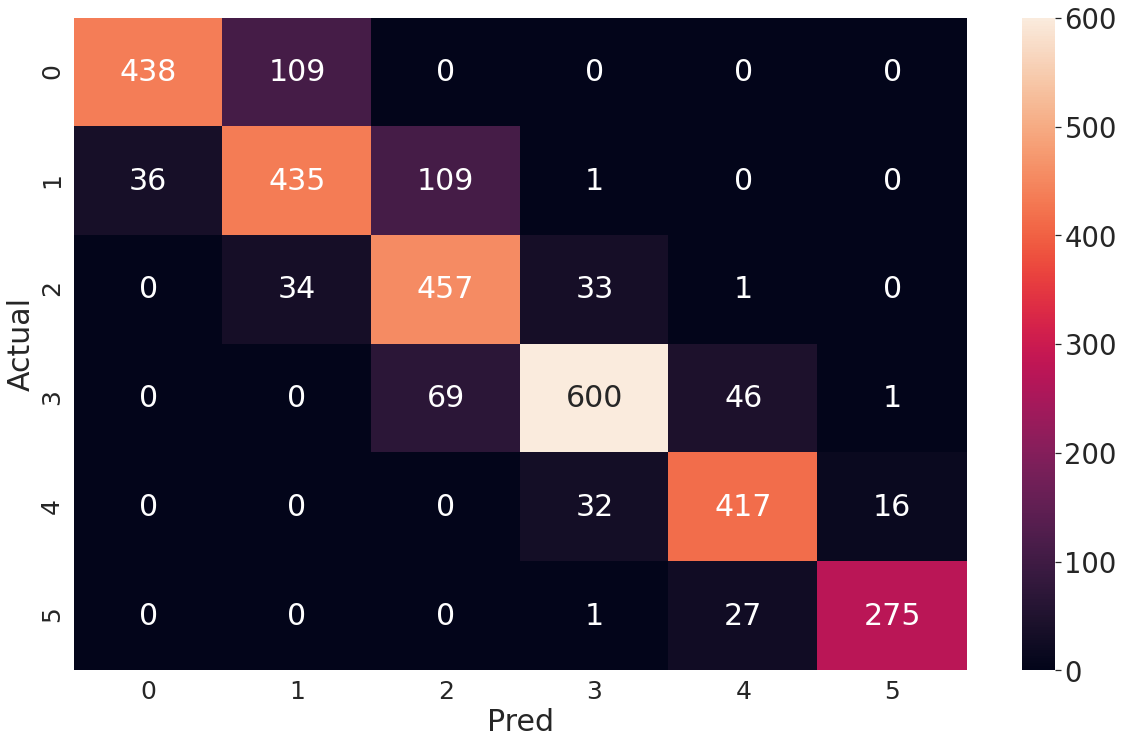

In [ ]:
y = [i.argmax() for i in y_test]
pred = [i.argmax() for i in Best_Predict_Test]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart2(cf_matrix_test, ocean + '_vanilla_cm_smote')

In [ ]:
with open("predictions_" + ocean + '_smote' + '.pkl', 'wb') as f: 
    pickle.dump([y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test], f)

In [ ]:
report_df = pd.DataFrame(report_test).transpose()
report_df = report_df.reset_index()
model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
report_df

,index,precision,recall,f1-score,support
0,0,0.924051,0.800731,0.857982,547.00000
1,1,0.752595,0.748709,0.750647,581.00000
2,2,0.719685,0.870476,0.787931,525.00000
3,3,0.899550,0.837989,0.867679,716.00000
4,4,0.849287,0.896774,0.872385,465.00000
5,5,0.941781,0.907591,0.924370,303.00000
6,accuracy,0.835830,0.835830,0.835830,0.83583
7,macro avg,0.847825,0.843712,0.843499,3137.00000
8,weighted avg,0.843132,0.835830,0.837140,3137.00000


In [ ]:
for i in range(report_df.shape[0]):
  tmp=""
  for j in ['precision', 'recall', 'f1-score', 'support']:
    tmp=tmp+ str(round(report_df[j][i],4)) + " & "
  print(tmp)

0.9241 & 0.8007 & 0.858 & 547.0 & 
0.7526 & 0.7487 & 0.7506 & 581.0 & 
0.7197 & 0.8705 & 0.7879 & 525.0 & 
0.8996 & 0.838 & 0.8677 & 716.0 & 
0.8493 & 0.8968 & 0.8724 & 465.0 & 
0.9418 & 0.9076 & 0.9244 & 303.0 & 
0.8358 & 0.8358 & 0.8358 & 0.8358 & 
0.8478 & 0.8437 & 0.8435 & 3137.0 & 
0.8431 & 0.8358 & 0.8371 & 3137.0 & 


In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

**Simple GAN**

In [ ]:
x_shuffled = X
y_shuffled = Y

In [ ]:
len(x_shuffled), len(X), len(y_shuffled)

(7322, 7322, 7322)

In [ ]:
t2 = np.asarray(x_shuffled).shape
X_oversampled = torch.from_numpy(np.asarray(x_shuffled))

In [ ]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )
class Generator(nn.Module):

    def __init__(self, z_dim=t2[1], im_dim=t2[1], hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    
    
    def get_gen(self):

        return self.gen
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)        
    )
class Discriminator(nn.Module):
    def __init__(self, im_dim=t2[1], hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):

        return self.disc(image)
    
    def get_disc(self):

        return self.dis
def get_noise(n_samples, z_dim, device='cuda'):

    return torch.randn(n_samples,z_dim,device=device) 

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 1000
z_dim = t2[1]
batch_size = 128
lr = 0.00001
display_step = 1
device = 'cuda'
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [ ]:
li=[]
for i in range(len(y_shuffled)):
    if int(y_shuffled[i])==2:
        li.append(x_shuffled[i])
        
len(y_shuffled), len(li)

(7322, 1190)

In [ ]:
X_real=np.array(li)
t3=X_real.shape
li2=[1]*(t3[0])
y_real=np.array(li2)
y_real.shape

(1190,)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(X_real) 
tensor_y = torch.Tensor(y_real)
my_dataset = TensorDataset(tensor_x,tensor_y)
dataloader = DataLoader(
    my_dataset,
    batch_size=batch_size,
    shuffle=True)

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True 
gen_loss = False
error = False

In [ ]:
samples_to_generate = int((X_oversampled.shape[0]-X_real.shape[0])/6)
print(samples_to_generate)

1022


In [ ]:
#epochs = [100,500,1000,2000,3000,4000,5000]
epochs = [5000]

In [ ]:
original_gan_data = dict()
both_class_gan_data = dict()

In [ ]:
for no_epoch in epochs:
  print("no of epochs: ", no_epoch)
  for epoch in range(no_epoch):
  
   
    for real, _ in tqdm(dataloader, disable=True):
        cur_batch_size = len(real)

       
        real = real.view(cur_batch_size, -1).to(device)

      
       
        disc_opt.zero_grad()

       
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        
        disc_loss.backward(retain_graph=True)

       
        disc_opt.step()

      
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

     
        mean_discriminator_loss += disc_loss.item() / display_step

  
        mean_generator_loss += gen_loss.item() / display_step

        if epoch%500==0:
            print(f"Epoch {epoch}: Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")

        if cur_step % display_step == 0 and cur_step > 0:
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
  fake_noise = get_noise(samples_to_generate, z_dim, device=device)
  res=gen(fake_noise)
  fres=res.cpu().detach().numpy()
  X_old=X
  finX=np.concatenate((X_old, fres), axis=0)
  y_fake = np.full(shape=samples_to_generate,fill_value=2)
  Y_old=np.asarray(Y)
  finY = np.append(Y_old, y_fake, axis=0)
  print(finX.shape, finY.shape)
  #idx = np.random.permutation(len(X_smote))
  idx = np.random.permutation(finX.shape[0])
  print(len(idx))
  x_shuffled = []
  y_shuffled = []
  xy=dict()
  for i in idx:
    #x_shuffled.append(X_smote[i])
    #y_shuffled.append(Y_smote[i])
    x_shuffled.append(finX[i])
    y_shuffled.append(finY[i])
  xy['x_shuffled']=x_shuffled
  xy['y_shuffled']=y_shuffled
  original_gan_data[no_epoch]=xy

no of epochs:  5000
Epoch 0: Step 0: Generator loss: 0.7421272993087769, discriminator loss: 0.6923505067825317
Epoch 0: Step 1: Generator loss: 1.484782099723816, discriminator loss: 1.3843377828598022
Epoch 0: Step 2: Generator loss: 0.7431156039237976, discriminator loss: 0.6917926073074341
Epoch 0: Step 3: Generator loss: 0.7436074018478394, discriminator loss: 0.6916486024856567
Epoch 0: Step 4: Generator loss: 0.7440751194953918, discriminator loss: 0.6912561655044556
Epoch 0: Step 5: Generator loss: 0.7445806860923767, discriminator loss: 0.690875768661499
Epoch 0: Step 6: Generator loss: 0.7450639009475708, discriminator loss: 0.6908825635910034
Epoch 0: Step 7: Generator loss: 0.7455576062202454, discriminator loss: 0.6908133029937744
Epoch 0: Step 8: Generator loss: 0.7460073232650757, discriminator loss: 0.6903039216995239
Epoch 0: Step 9: Generator loss: 0.7464237213134766, discriminator loss: 0.6899867057800293
Epoch 500: Step 5000: Generator loss: 0.6974006295204163, disc

In [ ]:
both_class_gan_data[1]=original_gan_data

In [ ]:
li=[]
for i in range(len(y_shuffled)):
    if int(y_shuffled[i])==1:
        li.append(x_shuffled[i])
        
len(y_shuffled), len(li)

X_real=np.array(li)
t3=X_real.shape
li2=[1]*(t3[0])
y_real=np.array(li2)
y_real.shape

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(X_real) 
tensor_y = torch.Tensor(y_real)
my_dataset = TensorDataset(tensor_x,tensor_y)
dataloader = DataLoader(
    my_dataset,
    batch_size=batch_size,
    shuffle=True)

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True 
gen_loss = False
error = False

In [ ]:
samples_to_generate = int((X_oversampled.shape[0]-X_real.shape[0])/6)
print(samples_to_generate)
original_gan_data = dict()


In [ ]:
for no_epoch in epochs:
  print("no of epochs: ", no_epoch)
  for epoch in range(no_epoch):
  
   
    for real, _ in tqdm(dataloader, disable=True):
        cur_batch_size = len(real)

       
        real = real.view(cur_batch_size, -1).to(device)

      
       
        disc_opt.zero_grad()

       
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        
        disc_loss.backward(retain_graph=True)

       
        disc_opt.step()

      
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

     
        mean_discriminator_loss += disc_loss.item() / display_step

  
        mean_generator_loss += gen_loss.item() / display_step

        if epoch%500==0:
            print(f"Epoch {epoch}: Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")

        if cur_step % display_step == 0 and cur_step > 0:
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
  fake_noise = get_noise(samples_to_generate, z_dim, device=device)
  res=gen(fake_noise)
  fres=res.cpu().detach().numpy()
  X_old=X
  finX=np.concatenate((X_old, fres), axis=0)
  y_fake = np.ones(samples_to_generate)
  Y_old=np.asarray(Y)
  finY = np.append(Y_old, y_fake, axis=0)
  print(finX.shape, finY.shape)
  #idx = np.random.permutation(len(X_smote))
  idx = np.random.permutation(finX.shape[0])
  print(len(idx))
  x_shuffled = []
  y_shuffled = []
  xy=dict()
  for i in idx:
    #x_shuffled.append(X_smote[i])
    #y_shuffled.append(Y_smote[i])
    x_shuffled.append(finX[i])
    y_shuffled.append(finY[i])
  xy['x_shuffled']=x_shuffled
  xy['y_shuffled']=y_shuffled
  original_gan_data[no_epoch]=xy

In [ ]:
both_class_gan_data[2]=original_gan_data

In [ ]:
with open(ocean + '_original_gan_data' + '.pkl', 'wb') as f: 
    pickle.dump([both_class_gan_data], f)

In [ ]:
len(original_gan_data[5000]['x_shuffled']), len(original_gan_data[5000]['y_shuffled'])

(8230, 8230)

In [ ]:
x_shuffled = original_gan_data[5000]['x_shuffled']
y_shuffled = original_gan_data[5000]['y_shuffled']

In [ ]:
len(test_Y), test_X.shape

(3137, (3137, 4))

In [ ]:
Y_hot_encoded_train =  np.asarray(to_categorical(y_shuffled))
#Y_hot_encoded_train = Y_hot_encoded_train.reshape(len(y_shuffled), n_steps_out, n_features_out)

Y_hot_encoded_test =  np.asarray(to_categorical(test_Y))
#Y_hot_encoded_test = Y_hot_encoded_test.reshape(len(test_Y), n_steps_out, n_features_out)

print(Y_hot_encoded_train.shape, Y_hot_encoded_test.shape)

(8344, 6) (3137, 6)


In [ ]:
test_X

array([[0.07142857, 0.07142857, 0.10714286, 0.10714286],
       [0.07142857, 0.10714286, 0.10714286, 0.14285714],
       [0.10714286, 0.10714286, 0.14285714, 0.17857143],
       ...,
       [0.07142857, 0.07142857, 0.07142857, 0.07142857],
       [0.07142857, 0.07142857, 0.07142857, 0.03571429],
       [0.07142857, 0.07142857, 0.03571429, 0.03571429]])

In [ ]:
x_shuffled[0], y_shuffled[0]

(array([0.16549467, 0.18916593, 0.21166302, 0.24223562]), 2)

In [ ]:
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
            x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))

In [ ]:
train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, report_train, report_test = MODEL_LSTM('vanilla', 'gan', univariate,x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs, Hidden)

Experiment 1 in progress
train acc:  0.8103883005547151
test acc:  0.7647058823529412
Experiment 2 in progress
train acc:  0.8156763590391908
test acc:  0.7726523887973641
Experiment 3 in progress
train acc:  0.8194336191218498
test acc:  0.7632027257240206
Total time for 3 experiments 1856.1967647075653
f1 scores for test data:  [0.76470588 0.77265239 0.76320273]


In [ ]:
with open("predictions_" + ocean + '_gan' + '.pkl', 'wb') as f: 
    pickle.dump([y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test], f)

**GAN Results**

In [ ]:
report_df = pd.DataFrame(report_test).transpose()
report_df = report_df.reset_index()
model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
report_df

,index,precision,recall,f1-score,support
0,0,0.908903,0.802559,0.852427,547.000000
1,1,0.740916,0.807229,0.772652,581.000000
2,2,0.705329,0.857143,0.773861,525.000000
3,3,0.915858,0.790503,0.848576,716.000000
4,4,0.834320,0.909677,0.870370,465.000000
5,5,0.957364,0.815182,0.880570,303.000000
6,accuracy,0.826905,0.826905,0.826905,0.826905
7,macro avg,0.843782,0.830382,0.833076,3137.000000
8,weighted avg,0.838933,0.826905,0.829003,3137.000000


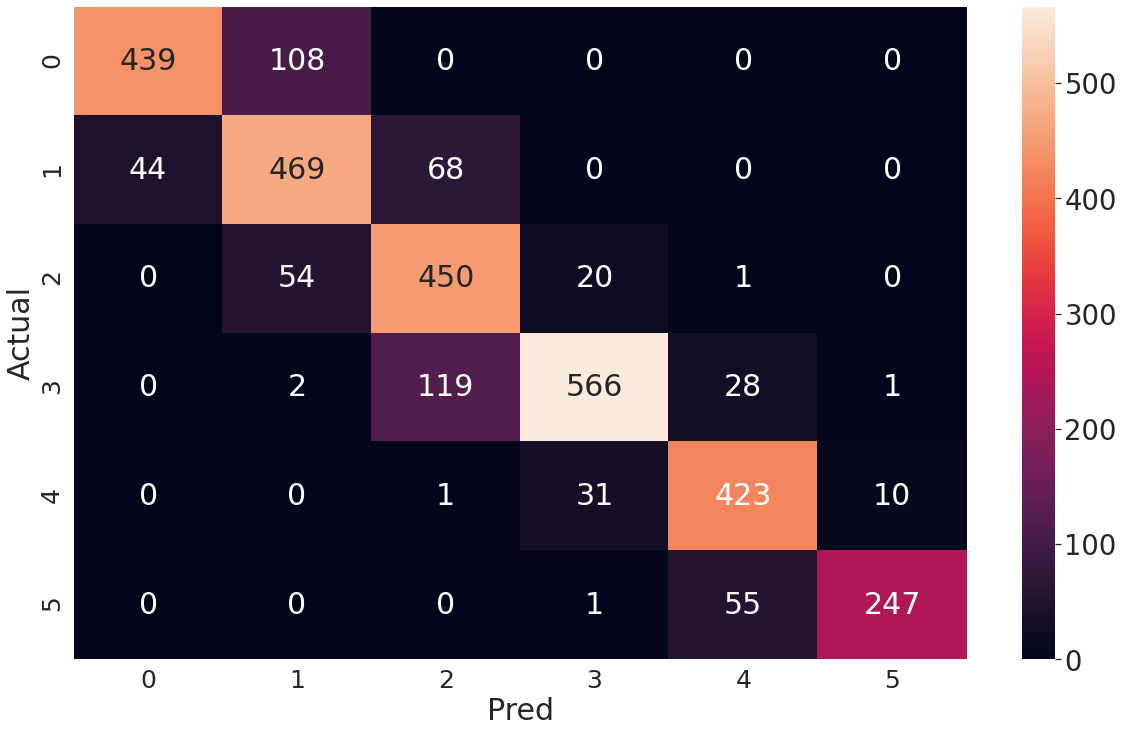

In [ ]:
y = [i.argmax() for i in y_test]
pred = [i.argmax() for i in Best_Predict_Test]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart2(cf_matrix_test, ocean + 'vanilla_cm_gan')

In [ ]:
f1_score(y, pred, average="micro")

0.826904686005738

In [ ]:
for i in range(report_df.shape[0]):
  tmp=""
  for j in ['precision', 'recall', 'f1-score', 'support']:
    tmp=tmp+ str(round(report_df[j][i],4)) + " & "
  print(tmp)

0.9089 & 0.8026 & 0.8524 & 547.0 & 
0.7409 & 0.8072 & 0.7727 & 581.0 & 
0.7053 & 0.8571 & 0.7739 & 525.0 & 
0.9159 & 0.7905 & 0.8486 & 716.0 & 
0.8343 & 0.9097 & 0.8704 & 465.0 & 
0.9574 & 0.8152 & 0.8806 & 303.0 & 
0.8269 & 0.8269 & 0.8269 & 0.8269 & 
0.8438 & 0.8304 & 0.8331 & 3137.0 & 
0.8389 & 0.8269 & 0.829 & 3137.0 & 


In [ ]:
torch.cuda.empty_cache()

In [ ]:
x_shuffled = X_smote
y_shuffled = Y_smote
print(len(x_shuffled), len(X), len(y_shuffled)) 
t2 = np.asarray(x_shuffled).shape
X_oversampled = torch.from_numpy(np.asarray(x_shuffled))

11790 7322 11790


In [ ]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )
class Generator(nn.Module):

    def __init__(self, z_dim=t2[1], im_dim=t2[1], hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    
    
    def get_gen(self):

        return self.gen
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)        
    )
class Discriminator(nn.Module):
    def __init__(self, im_dim=t2[1], hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):

        return self.disc(image)
    
    def get_disc(self):

        return self.dis
def get_noise(n_samples, z_dim, device='cuda'):

    return torch.randn(n_samples,z_dim,device=device) 

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 1000
z_dim = t2[1]
batch_size = 128
lr = 0.00001
display_step = 1
device = 'cuda'
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [ ]:
li=[]
for i in range(len(y_shuffled)):
    if int(y_shuffled[i])==2:
        li.append(x_shuffled[i])
        
print(len(y_shuffled), len(li))

X_real=np.array(li)
t3=X_real.shape
li2=[1]*(t3[0])
y_real=np.array(li2)
y_real.shape

from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(X_real) 
tensor_y = torch.Tensor(y_real)
my_dataset = TensorDataset(tensor_x,tensor_y)
dataloader = DataLoader(
    my_dataset,
    batch_size=batch_size,
    shuffle=True)

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True 
gen_loss = False
error = False

11790 1965


In [ ]:
samples_to_generate = int((X_oversampled.shape[0]-X_real.shape[0])/6)
print(samples_to_generate)

#epochs = [100,500,1000,2000,3000,4000,5000]
epochs = [5000]

smote_gan_data = dict()

1637


In [ ]:
for no_epoch in epochs:
  print("no of epochs: ", no_epoch)
  for epoch in range(no_epoch):
  
   
    for real, _ in tqdm(dataloader, disable=True):
        cur_batch_size = len(real)

       
        real = real.view(cur_batch_size, -1).to(device)

      
       
        disc_opt.zero_grad()

       
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        
        disc_loss.backward(retain_graph=True)

       
        disc_opt.step()

      
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

     
        mean_discriminator_loss += disc_loss.item() / display_step

  
        mean_generator_loss += gen_loss.item() / display_step

        if epoch%500==0:
            print(f"Epoch {epoch}: Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")

        if cur_step % display_step == 0 and cur_step > 0:
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
  fake_noise = get_noise(samples_to_generate, z_dim, device=device)
  res=gen(fake_noise)
  fres=res.cpu().detach().numpy()
  X_old=X
  finX=np.concatenate((X_old, fres), axis=0)
  y_fake = np.full(shape=samples_to_generate,fill_value=2)
  Y_old=np.asarray(Y)
  finY = np.append(Y_old, y_fake, axis=0)
  print(finX.shape, finY.shape)
  #idx = np.random.permutation(len(X_smote))
  idx = np.random.permutation(finX.shape[0])
  print(len(idx))
  x_shuffled = []
  y_shuffled = []
  xy=dict()
  for i in idx:
    #x_shuffled.append(X_smote[i])
    #y_shuffled.append(Y_smote[i])
    x_shuffled.append(finX[i])
    y_shuffled.append(finY[i])
  xy['x_shuffled']=x_shuffled
  xy['y_shuffled']=y_shuffled
  smote_gan_data[no_epoch]=xy

no of epochs:  5000
Epoch 0: Step 0: Generator loss: 0.6718560457229614, discriminator loss: 0.6935321092605591
Epoch 0: Step 1: Generator loss: 1.3445680141448975, discriminator loss: 1.3867679238319397
Epoch 0: Step 2: Generator loss: 0.6736675500869751, discriminator loss: 0.6929246187210083
Epoch 0: Step 3: Generator loss: 0.6745929718017578, discriminator loss: 0.6924919486045837
Epoch 0: Step 4: Generator loss: 0.6755198240280151, discriminator loss: 0.6922309398651123
Epoch 0: Step 5: Generator loss: 0.6763955950737, discriminator loss: 0.6919980049133301
Epoch 0: Step 6: Generator loss: 0.6771932244300842, discriminator loss: 0.6916148662567139
Epoch 0: Step 7: Generator loss: 0.6780276298522949, discriminator loss: 0.6913214921951294
Epoch 0: Step 8: Generator loss: 0.6788946390151978, discriminator loss: 0.6908305883407593
Epoch 0: Step 9: Generator loss: 0.6798319220542908, discriminator loss: 0.6904374957084656
Epoch 0: Step 10: Generator loss: 0.6806837320327759, discrimin

In [ ]:
with open(ocean + '_smote_gan_data' + '.pkl', 'wb') as f: 
    pickle.dump([smote_gan_data], f)

In [ ]:
print(len(smote_gan_data[5000]['x_shuffled']), len(smote_gan_data[5000]['y_shuffled']))
x_shuffled = smote_gan_data[5000]['x_shuffled']
y_shuffled = smote_gan_data[5000]['y_shuffled']
print(len(test_Y), test_X.shape)

Y_hot_encoded_train =  np.asarray(to_categorical(y_shuffled))
#Y_hot_encoded_train = Y_hot_encoded_train.reshape(len(y_shuffled), n_steps_out, n_features_out)

Y_hot_encoded_test =  np.asarray(to_categorical(test_Y))
#Y_hot_encoded_test = Y_hot_encoded_test.reshape(len(test_Y), n_steps_out, n_features_out)

print(Y_hot_encoded_train.shape, Y_hot_encoded_test.shape)

8959 8959
3137 (3137, 4)
(8959, 6) (3137, 6)


In [ ]:
test_X

array([[0.07142857, 0.07142857, 0.10714286, 0.10714286],
       [0.07142857, 0.10714286, 0.10714286, 0.14285714],
       [0.10714286, 0.10714286, 0.14285714, 0.17857143],
       ...,
       [0.07142857, 0.07142857, 0.07142857, 0.07142857],
       [0.07142857, 0.07142857, 0.07142857, 0.03571429],
       [0.07142857, 0.07142857, 0.03571429, 0.03571429]])

In [ ]:
x_shuffled[0], y_shuffled[0]

(array([0.0746505 , 0.11851136, 0.18593015, 0.24819653]), 2)

In [ ]:
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
            x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))

In [ ]:
train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, report_train, report_test = MODEL_LSTM('vanilla', 'smote_gan', univariate,x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs, Hidden)

Experiment 1 in progress
train acc:  0.8128342245989305
test acc:  0.7672634271099744
Experiment 2 in progress
train acc:  0.8235916424226395
test acc:  0.7726120033812341
Experiment 3 in progress
train acc:  0.8325863432639072
test acc:  0.7792869269949066
Total time for 3 experiments 1990.2514040470123
f1 scores for test data:  [0.76726343 0.772612   0.77928693]


In [ ]:
with open("predictions_" + ocean + '_smote_gan' + '.pkl', 'wb') as f: 
    pickle.dump([y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test], f)

**SMOTE GAN results**

In [ ]:
report_df = pd.DataFrame(report_test).transpose()
report_df = report_df.reset_index()
model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
report_df

,index,precision,recall,f1-score,support
0,0,0.894531,0.837294,0.864967,547.00000
1,1,0.768844,0.790017,0.779287,581.00000
2,2,0.752613,0.822857,0.786169,525.00000
3,3,0.886957,0.854749,0.870555,716.00000
4,4,0.808429,0.907527,0.855117,465.00000
5,5,0.954545,0.762376,0.847706,303.00000
6,accuracy,0.833280,0.833280,0.833280,0.83328
7,macro avg,0.844320,0.829137,0.833967,3137.00000
8,weighted avg,0.838807,0.833280,0.834059,3137.00000


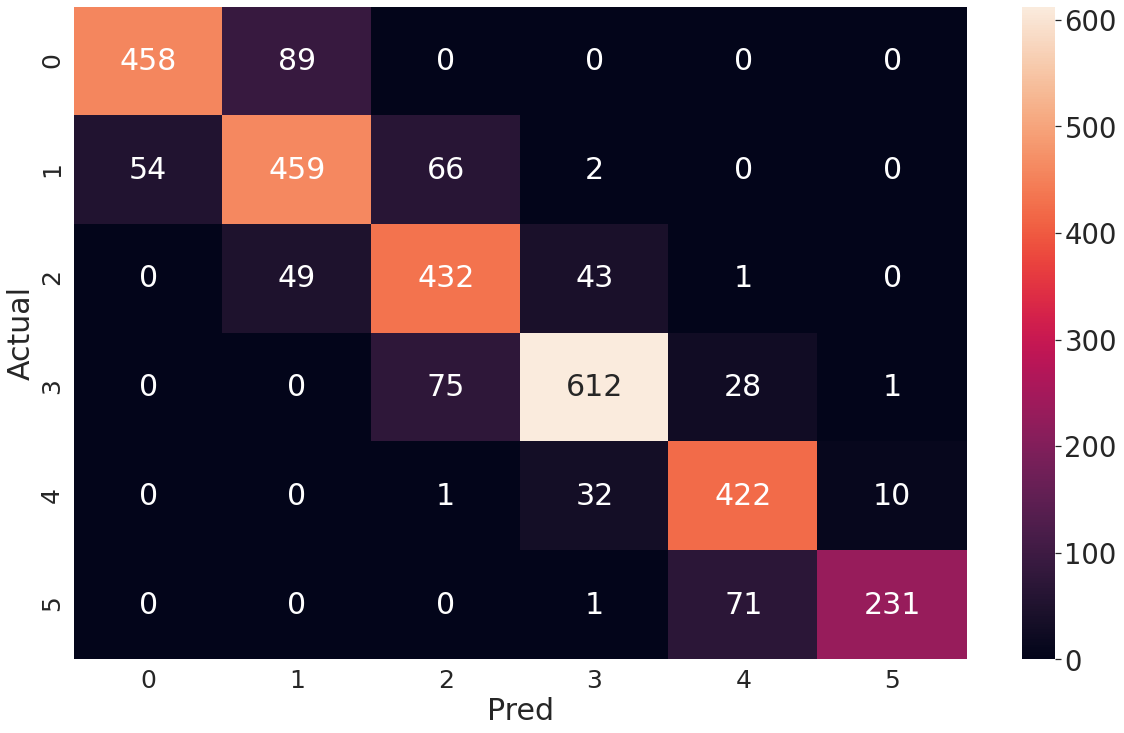

In [ ]:
y = [i.argmax() for i in y_test]
pred = [i.argmax() for i in Best_Predict_Test]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart2(cf_matrix_test, ocean + 'vanilla_cm_smote_gan')

In [ ]:
for i in range(report_df.shape[0]):
  tmp=""
  for j in ['precision', 'recall', 'f1-score', 'support']:
    tmp=tmp+ str(round(report_df[j][i],4)) + " & "
  print(tmp)

0.8945 & 0.8373 & 0.865 & 547.0 & 
0.7688 & 0.79 & 0.7793 & 581.0 & 
0.7526 & 0.8229 & 0.7862 & 525.0 & 
0.887 & 0.8547 & 0.8706 & 716.0 & 
0.8084 & 0.9075 & 0.8551 & 465.0 & 
0.9545 & 0.7624 & 0.8477 & 303.0 & 
0.8333 & 0.8333 & 0.8333 & 0.8333 & 
0.8443 & 0.8291 & 0.834 & 3137.0 & 
0.8388 & 0.8333 & 0.8341 & 3137.0 & 


**Recall Precision curves**

In [ ]:
with open(ocean + '_original' + '.pkl', 'rb') as f: 
    predictions_train,actual_train,predictions_test,actual_test,metrics_train,metrics_test=pickle.load(f)

FileNotFoundError: ignored

In [ ]:
lr_probs = predictions_test['1']['vanilla']
lr_probs = lr_probs[:, 1]
print(lr_probs)
testy= [i.argmax() for i in actual_test['1']['vanilla']]
yhat= [i.argmax() for i in predictions_test['1']['vanilla']]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

In [ ]:
with open(ocean + '_smote' + '.pkl', 'rb') as f: 
    y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test = pickle.load(f)

In [ ]:
lr_probs = Best_Predict_Test
lr_probs = lr_probs[:, 1]
print(lr_probs)
testy= [i.argmax() for i in y_test]
yhat= [i.argmax() for i in Best_Predict_Test]
lr_precision_smote, lr_recall_smote, _ = precision_recall_curve(testy, lr_probs)
lr_f1_smote, lr_auc_smote = f1_score(testy, yhat), auc(lr_recall_smote, lr_precision_smote)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_smote, lr_auc_smote))

[1.1074743e-05 6.3150111e-08 1.6548815e-14 ... 0.0000000e+00 7.0161540e-38
 0.0000000e+00]
Logistic: f1=0.412 auc=0.441


In [ ]:
with open(ocean + '_gan' + '.pkl', 'rb') as f: 
    y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test = pickle.load(f)

In [ ]:
lr_probs = Best_Predict_Test
lr_probs = lr_probs[:, 1]
print(lr_probs)
testy= [i.argmax() for i in y_test]
yhat= [i.argmax() for i in Best_Predict_Test]
lr_precision_gan, lr_recall_gan, _ = precision_recall_curve(testy, lr_probs)
lr_f1_gan, lr_auc_gan = f1_score(testy, yhat), auc(lr_recall_gan, lr_precision_gan)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_gan, lr_auc_gan))

[9.4767656e-06 3.2954503e-08 8.3283688e-14 ... 1.4457894e-24 8.8807153e-18
 4.9987783e-08]
Logistic: f1=0.414 auc=0.366


In [ ]:
with open(ocean + '_smote_gan' + '.pkl', 'rb') as f: 
    y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test = pickle.load(f)

In [ ]:
lr_probs = Best_Predict_Test
lr_probs = lr_probs[:, 1]
print(lr_probs)
testy= [i.argmax() for i in y_test]
yhat= [i.argmax() for i in Best_Predict_Test]
lr_precision_smote_gan, lr_recall_smote_gan, _ = precision_recall_curve(testy, lr_probs)
lr_f1_smote_gan, lr_auc_smote_gan = f1_score(testy, yhat), auc(lr_recall_smote_gan, lr_precision_smote_gan)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_smote_gan, lr_auc_smote_gan))

[3.9632655e-06 2.7184500e-05 2.6135458e-09 ... 1.6819697e-16 3.0762350e-12
 7.5718948e-10]
Logistic: f1=0.509 auc=0.518


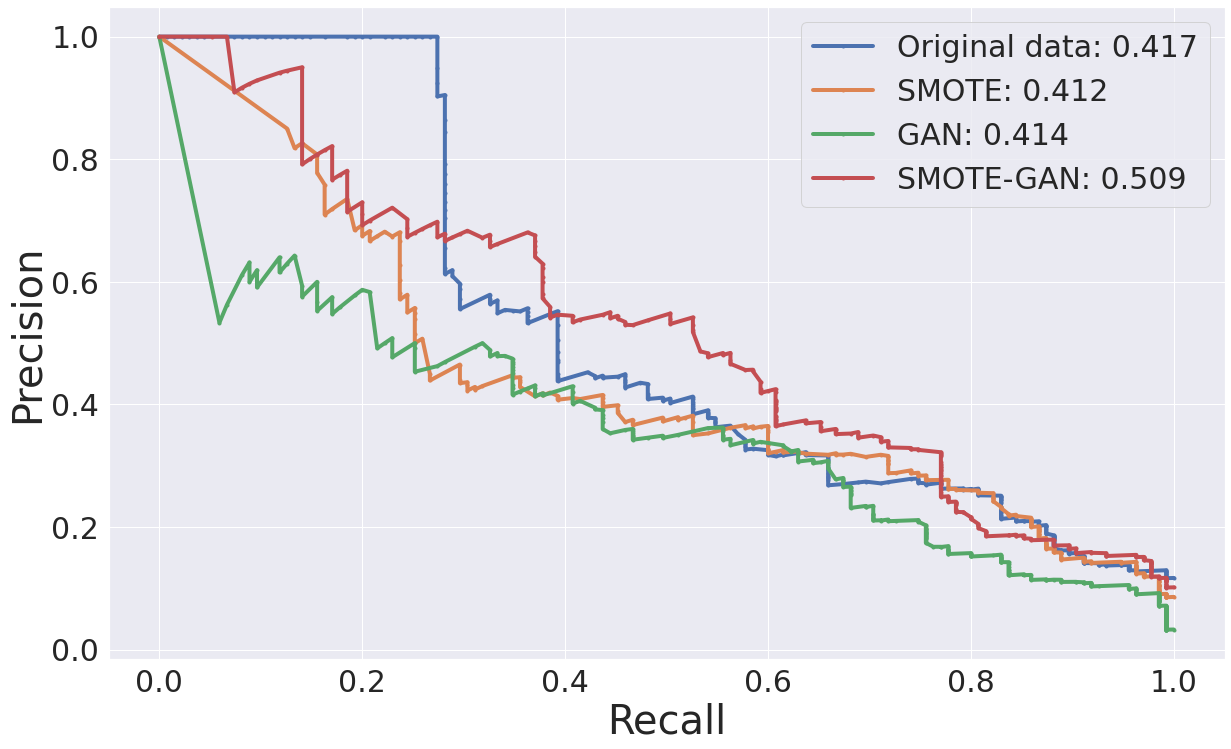

In [ ]:
# plot the precision-recall curves
fig, ax = pyplot.subplots(figsize = (20,12))
no_skill = 135 / len(testy)    #no of one/total
pyplot.plot(lr_recall, lr_precision, marker='.',lw=4, label='Original data: ' + str(round(lr_f1,3)))
pyplot.plot(lr_recall_smote, lr_precision_smote,lw=4, marker='.', label='SMOTE: ' + str(round(lr_f1_smote,3)))
pyplot.plot(lr_recall_gan, lr_precision_gan,lw=4, marker='.', label='GAN: ' + str(round(lr_f1_gan,3)))
pyplot.plot(lr_recall_smote_gan, lr_precision_smote_gan,lw=4, marker='.', label='SMOTE-GAN: ' + str(round(lr_f1_smote_gan,3)))
# axis labels
pyplot.xlabel('Recall', size=40)
pyplot.ylabel('Precision', size=40)
ax.tick_params(axis='both', which='major', labelsize=30)
# show the legend
pyplot.legend(loc="upper right", fontsize=30)
#save the plot
plt.savefig(ocean + '_precision_recall_curve.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
# show the plot
pyplot.show()